In [129]:
%matplotlib inline

In [130]:
import os
os.chdir("/home/jptalusan/mta_stationing_problem")
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import mean_squared_error
from ast import literal_eval
import sys
print(os.getcwd())
from src.config import *
from pandas.core.common import SettingWithCopyWarning
from src import data_utils, triplevel_utils
from src import day_ahead_prediction_utils, any_day_prediction_utils
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.set_option('display.max_columns', None)
import xgboost as xgb
import importlib
importlib.reload(data_utils)
import matplotlib as mpl

from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

/media/seconddrive/mta_stationing_problem


# Plotting Same Day stop level evaluation

In [9]:
## Separate mean and max from baseline
fp = os.path.join('evaluation', 'same_day', 'baseline_multi_stop_10P_xF_results_max_mean.pkl')
df = pd.read_pickle(fp)
df = df.bfill()

df_max = df[['trip_id', 'y_true', 'y_pred_max']]
df_max = df_max.rename({'y_pred_max':'y_pred'}, axis=1)
fp = os.path.join('evaluation', 'same_day', 'baseline_multi_stop_10P_xF_results_max.pkl')
df_max.to_pickle(fp)

df_mean = df[['trip_id', 'y_true', 'y_pred_ave']]
df_mean = df_mean.rename({'y_pred_ave':'y_pred'}, axis=1)
fp = os.path.join('evaluation', 'same_day', 'baseline_multi_stop_10P_xF_results_mean.pkl')
df_mean.to_pickle(fp)

fp = os.path.join('evaluation', 'same_day', 'simple_baseline_multi_stop_10P_xF_results_school_break.pkl')
df_simple = pd.read_pickle(fp)

fp = os.path.join('evaluation', 'same_day', 'SIMPLE_LSTM_multi_stop_5P_xF_results_school_break.pkl')
df_lstm = pd.read_pickle(fp)

In [11]:
def get_mse(x, length=None):
    if not length:
        y_true = [int(float(y)) for y in x.y_true]
        y_pred = [int(float(y)) for y in x.y_pred]
    else:
        if len(x.y_true) < length:
            length = len(x.y_true)
        y_true = [int(float(y)) for y in x.y_true[0:length]]
        y_pred = [int(float(y)) for y in x.y_pred[0:length]]
        
    return mean_squared_error(y_true, y_pred)
        
res_df_arr = []
multi_stop_results = ['SIMPLE_LSTM_multi_stop_5P_xF_results_school_break.pkl', 
                      'simple_baseline_multi_stop_10P_xF_results_school_break.pkl',
                      'baseline_multi_stop_10P_xF_results_max.pkl',
                      'baseline_multi_stop_10P_xF_results_mean.pkl']
for ms_result in multi_stop_results:
    fp = os.path.join('evaluation/same_day/', ms_result)
    res_df = pd.read_pickle(fp)[:200].bfill()
    res_df = res_df.groupby('trip_id').agg(list)
    res_df['mse'] = res_df.apply(lambda x: get_mse(x), axis=1)
    res_df['mse_1'] = res_df.apply(lambda x: get_mse(x, 1), axis=1)
    res_df['mse_5'] = res_df.apply(lambda x: get_mse(x, 5), axis=1)
    res_df['mse_10'] = res_df.apply(lambda x: get_mse(x, 10), axis=1)
    res_df_arr.append(res_df)

['', 'mse_1', '', 'mse_5', '', 'mse_10', '', 'mse', '']


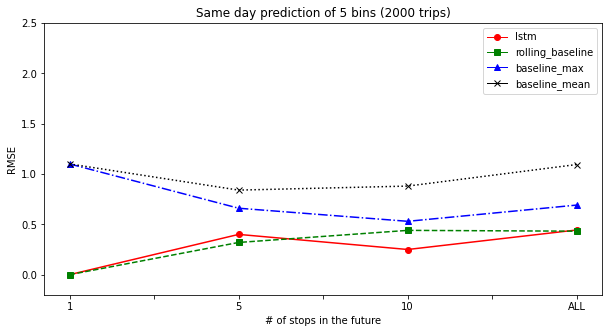

In [13]:
import matplotlib.pyplot as plt
# Plot ave MSE
fig, ax = plt.subplots(figsize=(10, 5))

marker = ['o', 's', '^', 'x']
color = ['r', 'g', 'b', 'k']
linestyle = ['-', '--', '-.', ':']
for i, line in enumerate(res_df_arr):
    
    res_df_arr[i][['mse_1', 'mse_5', 'mse_10', 'mse']].mean().plot(ax=ax, marker=marker[i], color=color[i], linestyle=linestyle[i])
    # line.set_marker(marker[i])
    # line.set_color(color[i])
#     # line.set_linestyle(linestyle[i])
labels = [item.get_text() for item in ax.get_xticklabels()]
print(labels)
labels[1] = 1
labels[3] = 5
labels[5] = 10
labels[7] = 'ALL'

ax.set_xticklabels(labels)

ax.set_ylabel('RMSE')
ax.set_xlabel('# of stops in the future')
from matplotlib.lines import Line2D
custom_lines = [
                Line2D([0], [0], color='red', lw=1, marker='o'),
                Line2D([0], [0], color='green', lw=1, marker='s'),
                Line2D([0], [0], color='blue', lw=1, marker='^'),
                Line2D([0], [0], color='k', lw=1, marker='x'),
               ]
ax.set_ylim(-0.2, 2.5)
ax.legend(custom_lines, ['lstm', 'rolling_baseline', 'baseline_max', 'baseline_mean'])
ax.set_title("Same day prediction of 5 bins (2000 trips)")
fp = os.path.join('plots', 'stop_level_prediction.png')
plt.savefig(fp, dpi=200, bbox_inches='tight')

### Evaluating using MAPE

              precision    recall  f1-score   support

         0.0       0.71      0.69      0.70     19930
         1.0       0.57      0.56      0.56     17487
         2.0       0.73      0.77      0.75     16847
         3.0       0.64      0.46      0.54       314
         4.0       1.00      0.03      0.05        75

    accuracy                           0.67     54653
   macro avg       0.73      0.50      0.52     54653
weighted avg       0.67      0.67      0.67     54653

              precision    recall  f1-score   support

         0.0       0.60      0.10      0.17     16377
         1.0       0.33      0.22      0.26     14132
         2.0       0.37      0.82      0.51     13855
         3.0       0.08      0.22      0.12       281
         4.0       0.03      0.27      0.06        51

    accuracy                           0.36     44696
   macro avg       0.28      0.33      0.23     44696
weighted avg       0.44      0.36      0.30     44696

              precisio

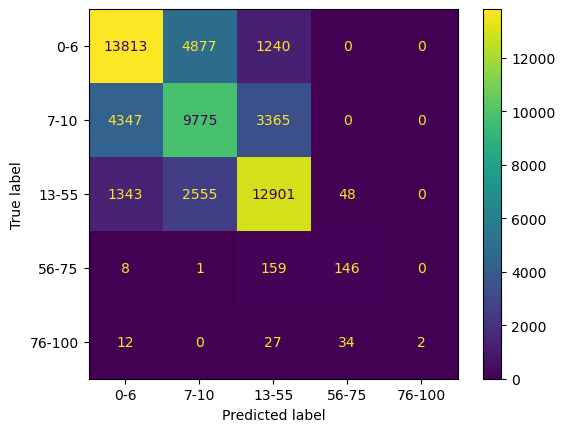

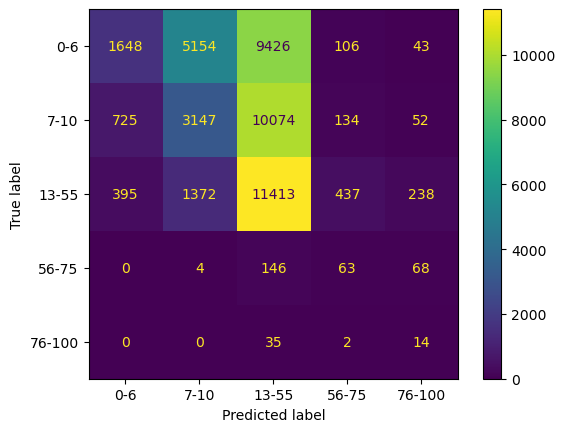

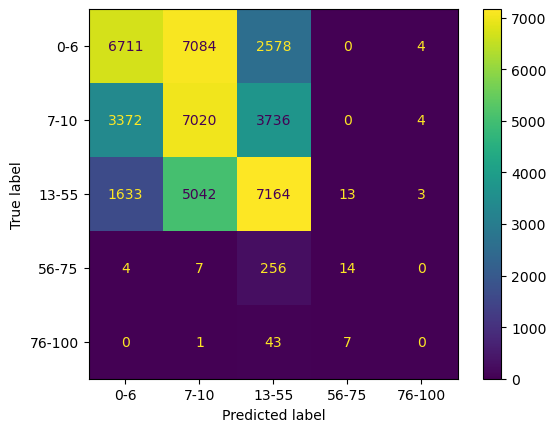

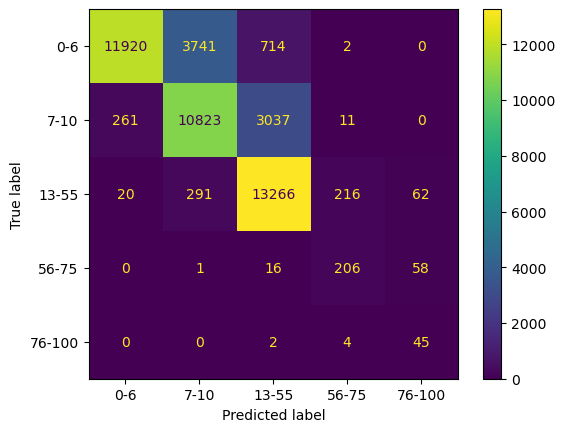

In [96]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

print(classification_report(df_lstm['y_true'], df_lstm['y_pred']))
print(classification_report(df_max['y_true'], df_max['y_pred']))
print(classification_report(df_mean['y_true'], df_mean['y_pred']))
print(classification_report(df_simple['y_true'], df_simple['y_pred']))

# labels = [(0.0, 6.0), (7.0, 12.0), (13.0, 55.0), (56.0, 75.0), (76.0, 100.0)]
labels = ["0-6", "7-10", "13-55", "56-75", "76-100"]
ConfusionMatrixDisplay.from_predictions(df_lstm['y_true'], df_lstm['y_pred'], values_format = 'd', display_labels=labels)
ConfusionMatrixDisplay.from_predictions(df_max['y_true'], df_max['y_pred'], values_format = 'd', display_labels=labels)
ConfusionMatrixDisplay.from_predictions(df_mean['y_true'], df_mean['y_pred'], values_format = 'd', display_labels=labels)
ConfusionMatrixDisplay.from_predictions(df_simple['y_true'], df_simple['y_pred'], values_format = 'd', display_labels=labels)

In [65]:
from sklearn.metrics import mean_absolute_percentage_error

mape_lstm = mean_absolute_percentage_error(df_lstm['y_true'], df_lstm['y_pred'])
mape_simple = mean_absolute_percentage_error(df_simple['y_true'], df_simple['y_pred'])
mape_base_max = mean_absolute_percentage_error(df_max['y_true'], df_max['y_pred'])
mape_base_mean = mean_absolute_percentage_error(df_mean['y_true'], df_mean['y_pred'])
print(f"{mape_lstm:.2E}, {mape_simple:.2E}, {mape_base_max:.2E}, {mape_base_mean:.2E}")

6.06E+14, 5.21E+14, 2.47E+15, 1.23E+15


# Comparing Day Ahead and Any Day with baselines

In [77]:
# Define evaluator, requires some time information (merge testX, testY and pred)
def generate_results_over_time_window(results_df_arr):
    mse_df = pd.DataFrame()
    for i, results_df in enumerate(results_df_arr):
        tdf = results_df[['time_window', 'y_pred', 'y_true']].groupby('time_window').agg({'y_pred': list, 'y_true': list})
        tdf['mse'] = tdf.apply(lambda x: mean_squared_error(x.y_true, x.y_pred, squared=False), axis=1)
        mse_df[i] = tdf['mse']
    return mse_df

## Day Ahead

In [14]:
mpl.rcParams.update(mpl.rcParamsDefault)

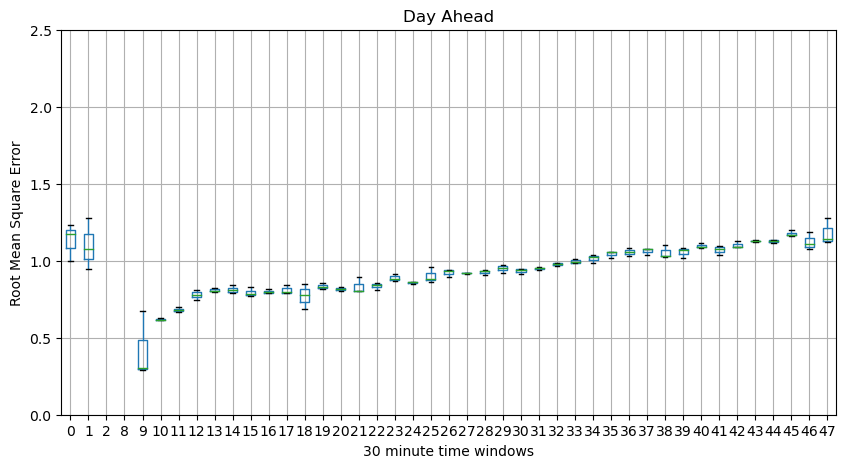

In [18]:
fp = os.path.join('evaluation', 'day_ahead', 'day_ahead_012_results_schoolbreak.pkl')
mse_df_012 = pd.read_pickle(fp)
fp = os.path.join('evaluation', 'day_ahead', 'day_ahead_234_results_schoolbreak.pkl')
mse_df_234 = pd.read_pickle(fp)
mse_df = mse_df_012 + mse_df_234

fig, ax = plt.subplots(figsize=(10, 5))
mse_df['time_window'] = mse_df.index
mse_df['time_window'].to_numpy()
mse_df['time_window'] = mse_df['time_window'].to_numpy().astype('int')
mse_df = mse_df.reset_index(drop=True).set_index('time_window')

mse_df.T.boxplot(ax=ax)

ax.set_title("Day Ahead")
ax.set_ylabel("Root Mean Square Error")
ax.set_xlabel("30 minute time windows")
ax.set_ylim(0.0, 2.5)

fp = os.path.join('plots', 'day_ahead_schoolbreak.png')
plt.savefig(fp, dpi=200, bbox_inches='tight')

## Any Ahead

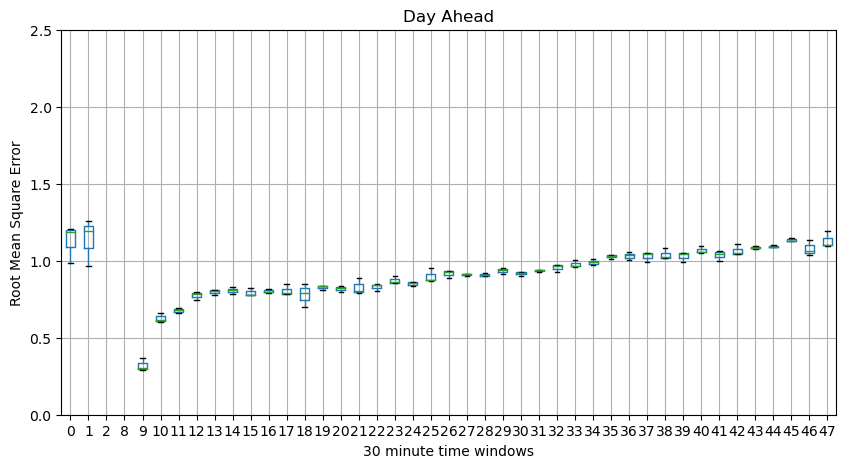

In [19]:
fp = os.path.join('evaluation', 'day_ahead', 'any_day_012_results_schoolbreak.pkl')
mse_df_012 = pd.read_pickle(fp)
fp = os.path.join('evaluation', 'day_ahead', 'any_day_234_results_schoolbreak.pkl')
mse_df_234 = pd.read_pickle(fp)
mse_df = mse_df_012 + mse_df_234

fig, ax = plt.subplots(figsize=(10, 5))
mse_df['time_window'] = mse_df.index
mse_df['time_window'].to_numpy()
mse_df['time_window'] = mse_df['time_window'].to_numpy().astype('int')
mse_df = mse_df.reset_index(drop=True).set_index('time_window')

mse_df.T.boxplot(ax=ax)

ax.set_title("Day Ahead")
ax.set_ylabel("Root Mean Square Error")
ax.set_xlabel("30 minute time windows")
ax.set_ylim(0.0, 2.5)

fp = os.path.join('plots', 'any_day_schoolbreak.png')
plt.savefig(fp, dpi=200, bbox_inches='tight')

## Baseline

In [23]:
fp = os.path.join('evaluation', 'day_ahead', 'baseline_012_results.pkl')
mse_df_012 = pd.read_pickle(fp)
fp = os.path.join('evaluation', 'day_ahead', 'baseline_234_results.pkl')
mse_df_234 = pd.read_pickle(fp)
mse_df = mse_df_012 + mse_df_234

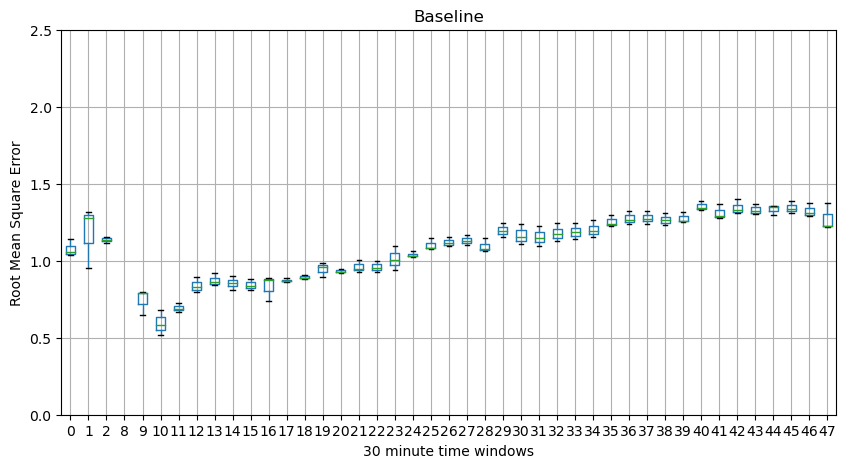

In [24]:
fig, ax = plt.subplots(figsize=(10, 5))
mse_df['time_window'] = mse_df.index
mse_df['time_window'].to_numpy()
mse_df['time_window'] = mse_df['time_window'].to_numpy().astype('int')
mse_df = mse_df.reset_index(drop=True).set_index('time_window')

mse_df.T.boxplot(ax=ax)

ax.set_title("Baseline")
ax.set_ylabel("Root Mean Square Error")
ax.set_xlabel("30 minute time windows")
ax.set_ylim(0.0, 2.5)

fp = os.path.join('plots', 'day_ahead_baseline.png')
plt.savefig(fp, dpi=200, bbox_inches='tight')

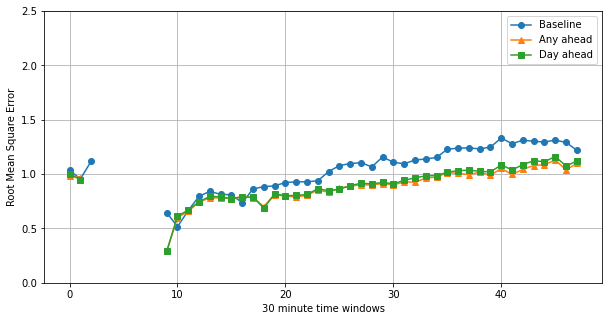

In [135]:
# Plotting all three with their minimums
fp = os.path.join('evaluation', 'day_ahead', 'done', 'day_ahead_012_results_schoolbreak.pkl')
# fp = os.path.join('evaluation', 'no_speed_simple_day_ahead_012_results_schoolbreak.pkl')
mse_df_012 = pd.read_pickle(fp)
fp = os.path.join('evaluation', 'day_ahead', 'done',  'day_ahead_234_results_schoolbreak.pkl')
# fp = os.path.join('evaluation', 'no_speed_simple_day_ahead_234_results_schoolbreak.pkl')
mse_df_234 = pd.read_pickle(fp)
mse_day_ahead_df = mse_df_012 + mse_df_234
mse_day_ahead_df['min'] = mse_day_ahead_df.min(axis=1)

fp = os.path.join('evaluation', 'day_ahead', 'done',  'any_day_012_results_schoolbreak.pkl')
# fp = os.path.join('evaluation', 'no_speed_simple_any_day_012_results_schoolbreak.pkl')
mse_df_012 = pd.read_pickle(fp)
fp = os.path.join('evaluation', 'day_ahead', 'done',  'any_day_234_results_schoolbreak.pkl')
# fp = os.path.join('evaluation', 'no_speed_simple_any_day_234_results_schoolbreak.pkl')
mse_df_234 = pd.read_pickle(fp)
mse_any_day_df = mse_df_012 + mse_df_234
mse_any_day_df['min'] = mse_any_day_df.min(axis=1)

fp = os.path.join('evaluation', 'day_ahead', 'done',  'baseline_012_results.pkl')
mse_df_012 = pd.read_pickle(fp)
fp = os.path.join('evaluation', 'day_ahead', 'done',  'baseline_234_results.pkl')
mse_df_234 = pd.read_pickle(fp)
mse_baseline_df = mse_df_012 + mse_df_234
mse_baseline_df['min'] = mse_baseline_df.min(axis=1)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(mse_baseline_df['min'], marker='o', label='Baseline')
ax.plot(mse_any_day_df['min'], marker='^', label='Any ahead')
ax.plot(mse_day_ahead_df['min'], marker='s', label='Day ahead')
ax.set_ylim(0, 2.5)
ax.set_ylabel("Root Mean Square Error")
ax.set_xlabel("30 minute time windows")
ax.grid()
ax.legend()
fp = os.path.join('plots', 'day_ahead.png')
plt.savefig(fp, dpi=200, bbox_inches='tight')

In [ ]:
mse_baseline_df
mse_any_day_df
mse_day_ahead_df

In [101]:
mse_day_ahead_df.index

Int64Index([ 0,  1,  2,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
            22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
            39, 40, 41, 42, 43, 44, 45, 46, 47],
           dtype='int64', name='time_window')

In [109]:
import plotly.graph_objects as go
import numpy as np

In [127]:
x = mse_baseline_df.index.tolist()
x_rev = x[::-1]
print(x + x_rev)
mse_baseline_y     = mse_baseline_df.median(axis=1).tolist()
mse_baseline_lower = mse_baseline_df.min(axis=1).tolist()
mse_baseline_upper = mse_baseline_df.max(axis=1).tolist()
mse_baseline_lower = mse_baseline_lower[::-1]

mse_any_day_y     = mse_any_day_df.median(axis=1).tolist()
mse_any_day_lower = mse_any_day_df.min(axis=1).tolist()
mse_any_day_upper = mse_any_day_df.max(axis=1).tolist()
mse_any_day_lower = mse_any_day_lower[::-1]

mse_day_ahead_y     = mse_day_ahead_df.median(axis=1).tolist()
mse_day_ahead_lower = mse_day_ahead_df.min(axis=1).tolist()
mse_day_ahead_upper = mse_day_ahead_df.max(axis=1).tolist()
mse_day_ahead_lower = mse_day_ahead_lower[::-1]


fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x+x_rev,
    y=mse_baseline_upper+mse_baseline_lower,
    fill='toself',
    fillcolor='rgba(0,100,80,0.2)',
    line_color='rgba(255,255,255,0)',
    showlegend=False,
    name='Baseline',
))
fig.add_trace(go.Scatter(
    x=x+x_rev,
    y=mse_any_day_upper+mse_any_day_lower,
    fill='toself',
    fillcolor='rgba(0,176,246,0.2)',
    line_color='rgba(255,255,255,0)',
    showlegend=False,
    name='Any Day',
))
fig.add_trace(go.Scatter(
    x=x+x_rev,
    y=mse_day_ahead_upper+mse_day_ahead_lower,
    fill='toself',
    fillcolor='rgba(231,107,243,0.2)',
    line_color='rgba(255,255,255,0)',
    showlegend=False,
    name='Day Ahead',
))
fig.add_trace(go.Scatter(
    x=x, y=mse_baseline_y,
    line_color='rgb(0,100,80)',
    name='Baseline',
))
fig.add_trace(go.Scatter(
    x=x, y=mse_any_day_y,
    line_color='rgb(0,176,246)',
    name='Any Day',
))
fig.add_trace(go.Scatter(
    x=x, y=mse_day_ahead_y,
    line_color='rgb(231,107,243)',
    name='Day Ahead',
))

fig.update_traces(mode='lines+markers')
fig.show()


[0, 1, 2, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 2, 1, 0]
